In [221]:
from Distillation_disc_cont import Simulator
from memory import Memory
from Actor_Critic import Agent
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
import dill

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
#dill.load_session('Agent.db')

In [223]:
%autoreload

## Make agent and define hyperparameters

In [224]:
alpha = 1e-3
beta = 1e-4 
gamma = 0.97

num_episodes = int(1e4)
memory_size = int(1e5)
batch_size = 50
pretrain_eps = batch_size

In [225]:
env = Simulator()
memory = Memory(max_size = memory_size)
agent = Agent(env = env, alpha = alpha, beta = beta, gamma = gamma, layer_size = 30)
agent.actor.summary()
#agent.critic.summary()
#agent.policy.summary()

Model: "model_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 6)            0                                            
__________________________________________________________________________________________________
fc1 (Dense)                     (None, 30)           210         Input[0][0]                      
__________________________________________________________________________________________________
fc2 (Dense)                     (None, 30)           930         fc1[0][0]                        
__________________________________________________________________________________________________
fc3 (Dense)                     (None, 30)           930         fc2[0][0]                        
___________________________________________________________________________________________

## Fill the experience memory

In [226]:
state = env.reset()

for ep in range(pretrain_eps):
    action = env.discrete_action_space.sample(), env.continuous_action_space.sample()
    next_state, reward, done, _ = env.step(action)
    
    if done:
        next_state = np.zeros(env.observation_space.shape)
        memory.add((state, action, reward, next_state))
        
    else:
        memory.add((state, action, reward, next_state))
        state = next_state
    

In [227]:
score_history = []
for i in range(num_episodes):
    
    done = False
    
    state = env.reset()
    score = 0
    
    while not done:
        action = agent.choose_action_epsgreedy(state, i, num_episodes)
        next_state, reward, done, info = env.step(action)
        #agent.learn(state,  action, reward, next_state, done)
        score += reward
        memory.add((state, action, reward, next_state))
        state = next_state
    
    score_history.append(score)
    next_state = np.zeros(state.shape)
    memory.add((state, action, reward, next_state))
    
    avg_score = np.mean(score_history[-100:]) #average of last 100 scores
    if i%100 == 0:
        print(f'episode {i}, avg_score {avg_score}, last action {action}')
        
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    rewards = np.array([each[2] for each in batch])
    next_states = np.array([each[3] for each in batch])
    
    agent.learn(states,  actions, rewards, next_states, done, batch_size, verbose = 1)    


episode 0, avg_score -1542.138485995535, last action (4, array([[-0.24012441]]))
episode 100, avg_score -1297.2067442069235, last action (2, array([[-0.16284093]]))
episode 200, avg_score -1097.659805671419, last action (2, array([[0.91274206]]))
episode 300, avg_score -938.0143255154842, last action (2, array([[0.39179336]]))
episode 400, avg_score -936.9526623297731, last action (2, array([[-0.24977556]]))
episode 500, avg_score -981.0626216239142, last action (2, array([[0.37308161]]))
episode 600, avg_score -991.7988878604154, last action (2, array([[-1.99877446]]))
episode 700, avg_score -987.6207589727519, last action (2, array([[-0.79934632]]))
episode 800, avg_score -1014.8524077585888, last action (2, array([[0.54244856]]))
episode 900, avg_score -1061.6322141325904, last action (2, array([[0.53378868]]))
episode 1000, avg_score -1119.0559107840586, last action (2, array([[0.62090463]]))
episode 1100, avg_score -1081.627083632507, last action (2, array([[-0.06567571]]))
episod

episode 9800, avg_score -1574.4521313639082, last action (1, array([[0.49400965]]))
episode 9900, avg_score -1573.3706846853227, last action (2, array([[0.50070384]]))


In [228]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

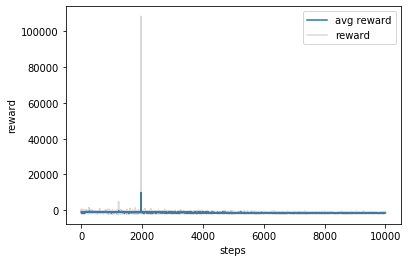

In [229]:
episodes = np.arange(num_episodes)
smoothed_rews = running_mean(score_history, 10)
plt.plot(episodes[-len(smoothed_rews):], smoothed_rews)
plt.plot(episodes, score_history,color='grey', alpha=0.3)
plt.xlabel("steps")
plt.ylabel("reward")
plt.legend(["avg reward", "reward"])

In [230]:
#test agent
state = env.reset()
done = False
while not done:
    state = state[np.newaxis, :]
    action_discrete, action_continuous = agent.policy.predict(state)
    action_discrete = np.argmax(action_discrete)
    action = action_discrete, action_continuous
    
    state, reward, done, info = env.step(action)
    print(f'action LK: {action_discrete}, action split: {action_continuous[0]}, reward: {reward}')

action LK: 2, action split: [0.5], reward: -0.12775379014095772
action LK: 2, action split: [0.5], reward: -100
action LK: 2, action split: [0.5], reward: -100
action LK: 2, action split: [0.5], reward: -100
action LK: 2, action split: [0.5], reward: -100
action LK: 2, action split: [0.5], reward: -100
action LK: 2, action split: [0.5], reward: -100
action LK: 2, action split: [0.5], reward: -100
action LK: 2, action split: [0.5], reward: -100
action LK: 2, action split: [0.5], reward: -100
action LK: 2, action split: [0.5], reward: -100


In [231]:
env.stream_table

[array([9.1, 6.8, 9.1, 6.8, 6.8, 6.8]),
 array([9.1       , 6.8       , 4.55000019, 3.4000001 , 0.        ,
        0.        ]),
 array([0.        , 0.        , 4.54999981, 3.3999999 , 6.8       ,
        6.8       ]),
 array([9.1       , 6.8       , 2.2750001 , 1.70000005, 0.        ,
        0.        ]),
 array([0.        , 0.        , 2.2750001 , 1.70000005, 0.        ,
        0.        ]),
 array([0.        , 0.        , 2.27499986, 1.69999993, 0.        ,
        0.        ]),
 array([0.        , 0.        , 2.27499995, 1.69999998, 6.8       ,
        6.8       ]),
 array([9.1       , 6.8       , 1.13750005, 0.85000002, 0.        ,
        0.        ]),
 array([0.        , 0.        , 1.13750005, 0.85000002, 0.        ,
        0.        ]),
 array([0.        , 0.        , 1.13750005, 0.85000002, 0.        ,
        0.        ]),
 array([0.        , 0.        , 1.13750005, 0.85000002, 0.        ,
        0.        ]),
 array([0.        , 0.        , 1.13749993, 0.84999996, 0.  

In [193]:
action_discrete, action_continuous = agent.policy.predict(state[np.newaxis, :])

In [ ]:
#dill.dump_session('Agent.db')